## Outlier detection with STL_decomposition

STL( Seasonal and Trend decomposition using Loess) is a method for estimating non linear relationships.It handles any type of seasonality.It is easy to use as we can change its different parameters according to our data.We can control the seasonality and trend parameters of the algorithm.It can be robust to outliers mean  unusual observations will not affect the estimates of the trend-cycle and seasonal components.

STL contains three main parts seasonal,trend and residual.Pattern followed by the data over long period of time counts in trend while the periodic pattern which data follows is seasonality and the remainder is residual.It can be very useful in finding outliers by simply considering the residual part after removal of trend and seasonality from the data.

My approach is to consider the residual part and then create a band based on multiples of standard deviation and then points outside this band will be considered as outliers.Band will be decided according to the contamination factor given by the user.


In [1]:
import pandas as pd
import requests
import datetime
import json
import numpy as np
import seaborn as sns
from numpy import array
from numpy import hstack
import seaborn as sns
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

### Data Collection method

In [3]:
augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='/Users/pratikmishra/augur/augur.config.json')
augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='/Users/pratikmishra/augur/augur.config.json')

time_series = ['code-changes','code-changes-lines','issues-active','issues-closed',
              'contributors-new','reviews','issues-new',
              'open-issues-count','reviews-accepted','reviews-declined']
              
def time_series_metrics(repo_id):
    training_days = 365
    
    base_url = 'http://{}:{}/api/unstable/repo-groups/20/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)
    begin_date = datetime.datetime(2019, 3, 31, 0, 0)#datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
    index = pd.date_range(begin_date, periods=training_days, freq='D')
    df = pd.DataFrame(index)
    df.columns = ['date']
    df['date'] = df['date'].astype(str)

    for endpoint in time_series:
        #print(endpoint)
        
        url = base_url + endpoint
        print("Hitting endpoint: " + url + "\n")
        try:
            data = requests.get(url=url).json()
            #print(data)
        except:
            data = json.loads(json.dumps(requests.get(url=url).text))

        if len(data) == 0:
            print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
            continue
                    
        if 'date' not in data[0]:
            print("Endpoint {} is not a timeseries, moving to next endpoint.\n".format(endpoint))
            continue
                
        metric_df = pd.DataFrame.from_records(data)
        metric_df['date'] = pd.to_datetime(metric_df['date']).dt.date
        metric_df['date'] = metric_df['date'].astype(str)
        extra=['repo','rg','week','year']
        for column in metric_df.columns:
            if any(x in column for x in extra):
                metric_df.drop(column,axis=1,inplace=True)
                
        df = pd.DataFrame(pd.merge(df,metric_df.loc[:,metric_df.columns],how = 'left',on = 'date'))
        metric_df.drop('date',axis=1,inplace=True)
        df.rename(columns={i :"{} _ {}".format(endpoint, i) for i in metric_df.columns }, inplace=True)
    return df

### STL on Highly Active repos

#### repo_id : 25663 git url : :https://github.com/Spring-projects/spring-framework
#### Such repos are quite active daily and there is a continous workflow.Such repos were mainly open to all for contribution.
#### Monthly trend with weekly seasonality fits best for this repo.
#### Points outside 2nd or 3rd standard deviation are good to classify as outliers.
#### There is less chance of skipping any anomaly and also rare to raise a false positive signal

In [4]:
data = time_series_metrics(25663)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/code-changes

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-active

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-closed

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/contributors-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/open-issues-count

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews-accepted

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews-declined



In [5]:
data.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,106.0,393.0,147.0,5.0,5.0,5.0,NaN,7.0,NaN,NaN,NaN
1,2019-04-01,NaN,1109.0,647.0,NaN,11.0,2.0,2.0,4.0,6.0,NaN,1.0
2,2019-04-02,NaN,707.0,503.0,NaN,7.0,3.0,1.0,5.0,NaN,3.0,2.0
3,2019-04-03,NaN,1800.0,576.0,NaN,8.0,4.0,NaN,6.0,NaN,1.0,1.0
4,2019-04-04,NaN,793.0,409.0,2.0,6.0,3.0,1.0,13.0,NaN,1.0,1.0


In [6]:
data = data.fillna(0)

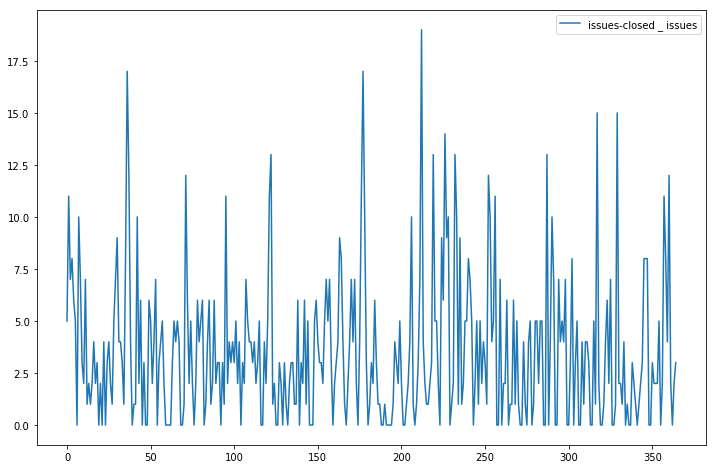

In [7]:
plt.figure(figsize=(12,8))
plt.plot(data.iloc[:,5])
plt.legend()

In [8]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(legend, frameon=False)




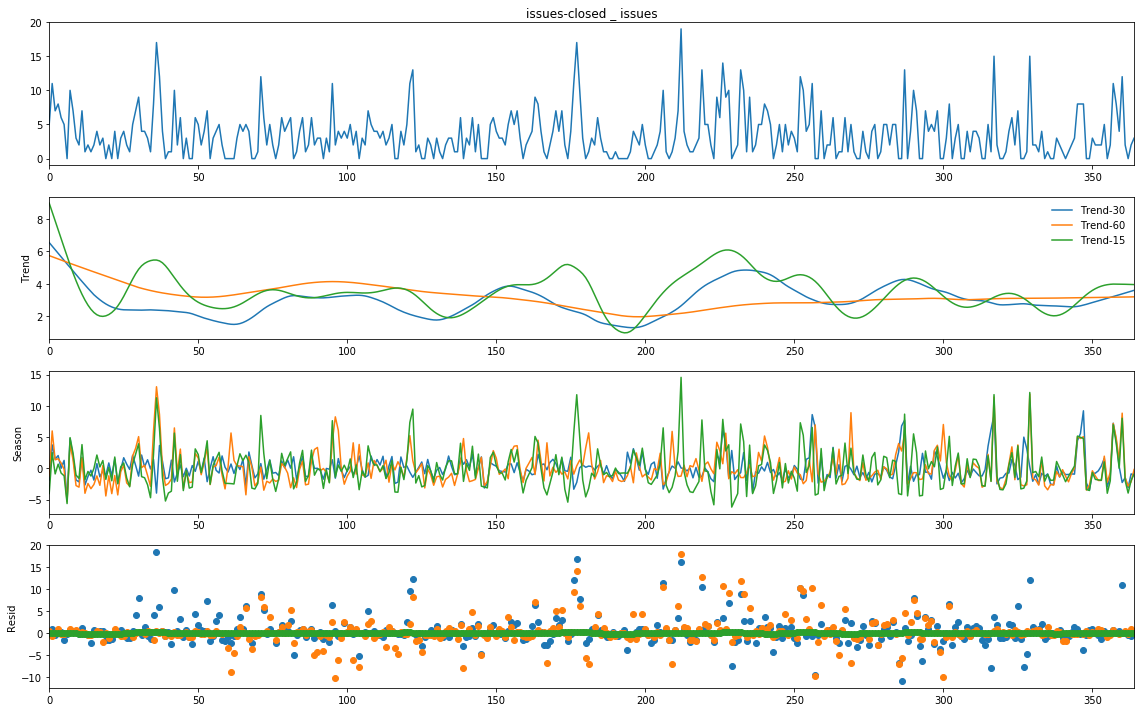

In [9]:

plt.rc('figure',figsize=(16,10))
stl = STL(data.iloc[:,5], seasonal=7,trend=31,period=30,robust=True)
res = stl.fit()
fig = res.plot()
res_non_robust = STL(data.iloc[:,5], seasonal=7,trend=61,period=60, robust=True).fit()
add_stl_plot(fig, res_non_robust,['Trend-30','Trend-60'])
res_non = STL(data.iloc[:,5], seasonal=3,trend=15,period=14, robust=True).fit()
add_stl_plot(fig, res_non, ['Trend-30','Trend-60','Trend-15'])
#plt.show()


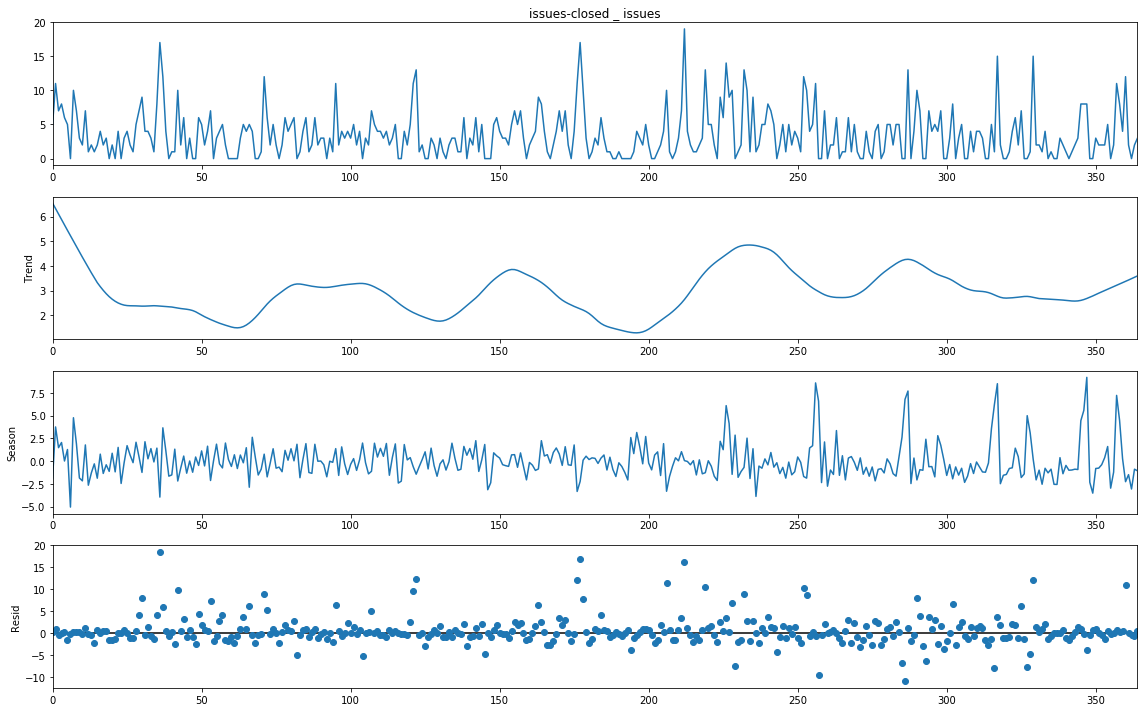

In [10]:
plt.rc('figure',figsize=(16,10))
stl = STL(data.iloc[:,5], seasonal=7,trend=31,period=30,robust=True)
res = stl.fit()
fig = res.plot()

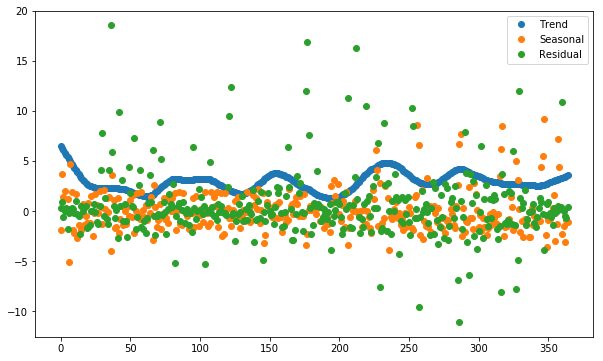

In [11]:
plt.figure(figsize=(10,6))
plt.plot(res.trend , 'o',label='Trend')
plt.plot(res.seasonal , 'o',label='Seasonal')
plt.plot(res.resid , 'o',label='Residual')
plt.legend()

In [12]:
std_resid = np.std(res.resid)
mean_resid = np.mean(res.resid)
print(std_resid)
print(mean_resid)

3.3440425907714313
0.544665779318721


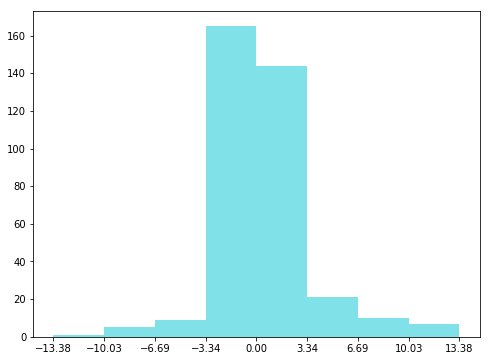

In [13]:
plt.figure(figsize=(8,6))
s=std_resid
bis = [-4*s,-3*s,-2*s,-s,0,s,2*s,3*s,4*s]
plt.hist(res.resid,bins=bis,color = '#80e1e8')
plt.xticks(bis)
plt.show()

In [14]:
np.mean(data.iloc[:,5])


3.5178082191780824

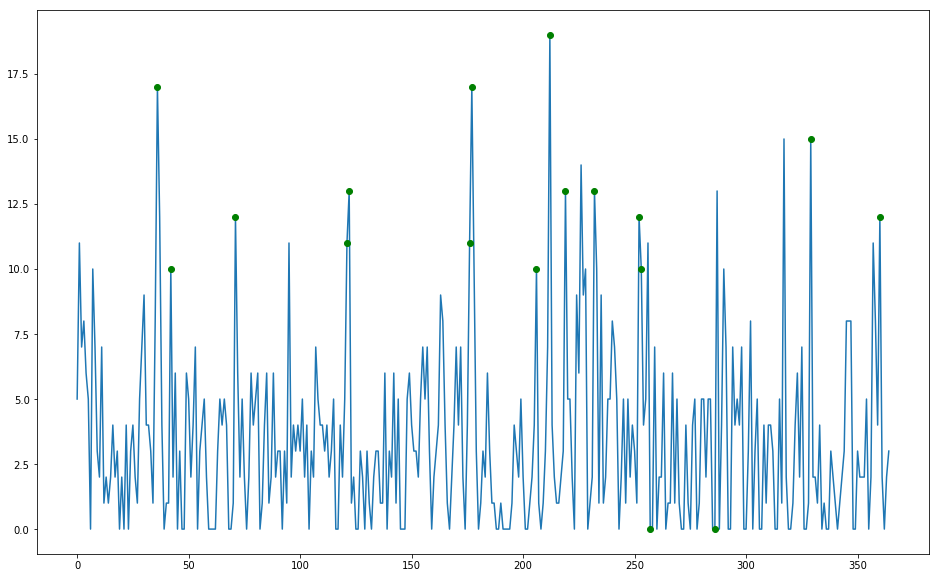

In [15]:
plt.figure(figsize=(16,10))
filt = (res.resid > 2.5*s) | (res.resid < -2.5*s)
plt.plot(data.iloc[:,5])
plt.plot(data[filt]['issues-closed _ issues'],'o',color='g')

In [16]:
data[filt]['issues-closed _ issues']

36     17.0
42     10.0
71     12.0
121    11.0
122    13.0
176    11.0
177    17.0
206    10.0
212    19.0
219    13.0
232    13.0
252    12.0
253    10.0
257     0.0
286     0.0
329    15.0
360    12.0
Name: issues-closed _ issues, dtype: float64

## Moderately Active Repo

#### repo_id = 25797 git url : https://github.com/Spring-projects/spring-session

#### Such repos are quite active but not on regular basis  that is, continous slowdown observed over certain period of time.
#### Monthly trend with weekly seasonality fits best for this repo.
#### Points outside 2nd standard deviation are good to classify as outliers.
#### There is less chance of skipping any anomaly and also rare to raise a false positive signal.

In [17]:
df = time_series_metrics(25797)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/code-changes

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/issues-active

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/issues-closed

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/contributors-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/reviews

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/open-issues-count

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/reviews-accepted

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/reviews-declined



In [18]:
df = df.fillna(0)

In [19]:
df.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2019-04-01,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,10.0,3.0
2,2019-04-02,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
3,2019-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


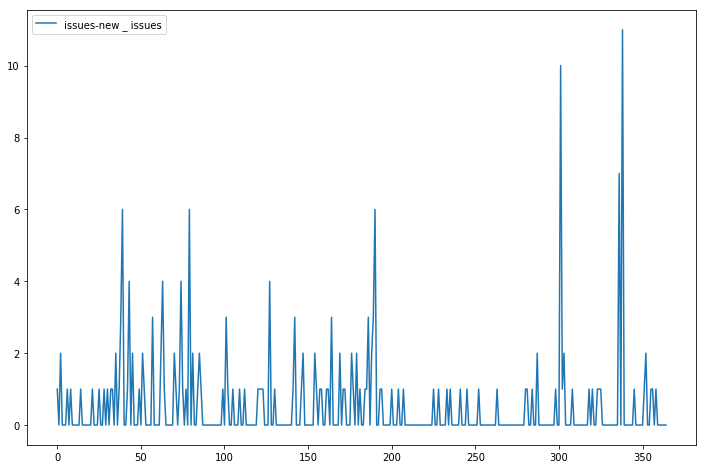

In [20]:
plt.figure(figsize=(12,8))
plt.plot(df.iloc[:,8])
plt.legend()

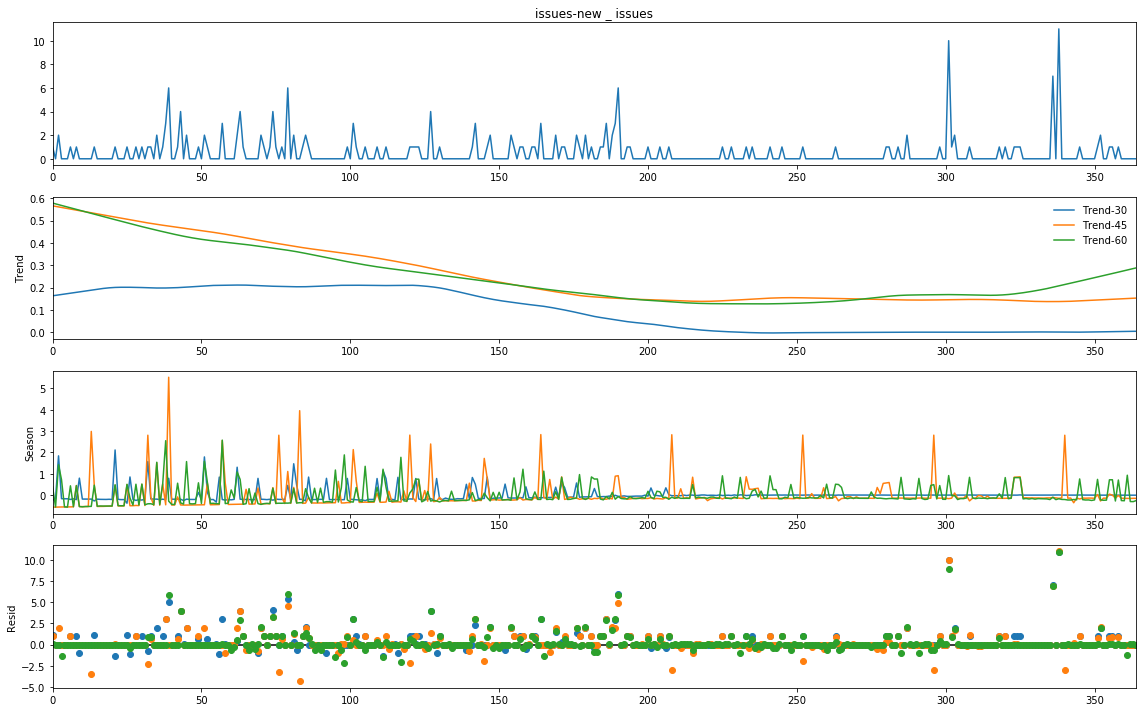

In [94]:
plt.rc('figure',figsize=(16,10))
stl = STL(df.iloc[:,8], seasonal=7,trend=31,period=30,robust=True)
res = stl.fit()
fig = res.plot()
res_non_robust = STL(df.iloc[:,8], seasonal=7,trend = 45,period=44, robust=True).fit()
add_stl_plot(fig, res_non_robust,['Trend-30','Trend-45'])
res_non = STL(df.iloc[:,8], seasonal=7,trend=61,period=60, robust=True).fit()
add_stl_plot(fig, res_non, ['Trend-30','Trend-45','Trend-60'])

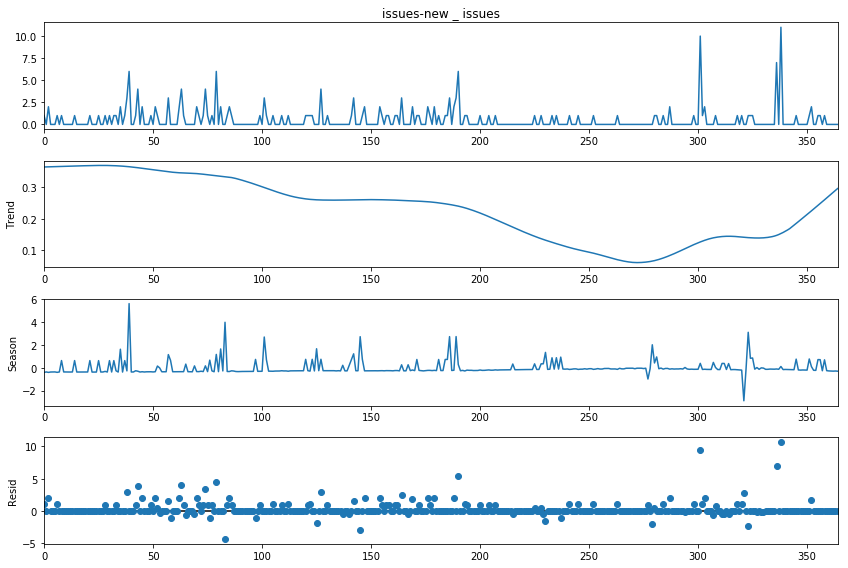

In [44]:
plt.rc('figure',figsize=(12,8))
stl = STL(df.iloc[:,8], seasonal=5,trend =45,period=44,robust=True)
res = stl.fit()
fig = res.plot()

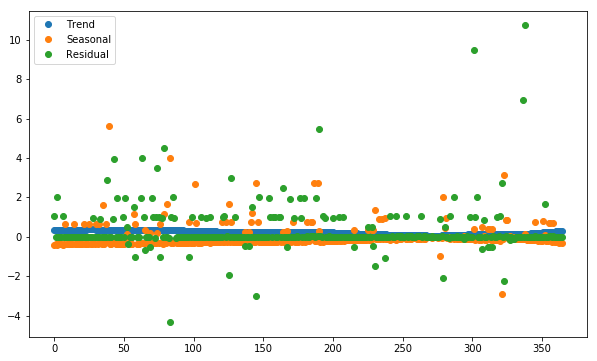

In [45]:
plt.figure(figsize=(10,6))
plt.plot(res.trend , 'o',label='Trend')
plt.plot(res.seasonal , 'o',label='Seasonal')
plt.plot(res.resid , 'o',label='Residual')
plt.legend()

In [46]:
std_resid = np.std(res.resid)
mean_resid = np.mean(res.resid)
print(std_resid)

1.1719166261600897


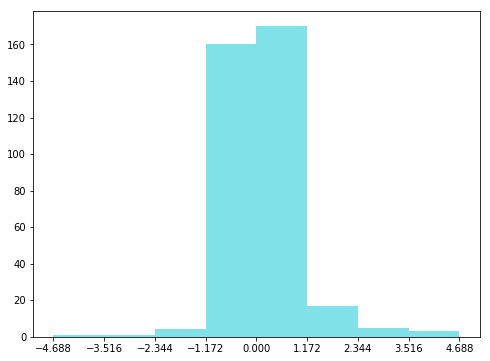

In [47]:
plt.figure(figsize=(8,6))
s=std_resid
bis = [-4*s,-3*s,-2*s,-s,0,s,2*s,3*s,4*s]
plt.hist(res.resid,bins=bis,color = '#80e1e8')
plt.xticks(bis)
plt.show()

In [48]:
np.mean(df.iloc[:,8])

0.5205479452054794

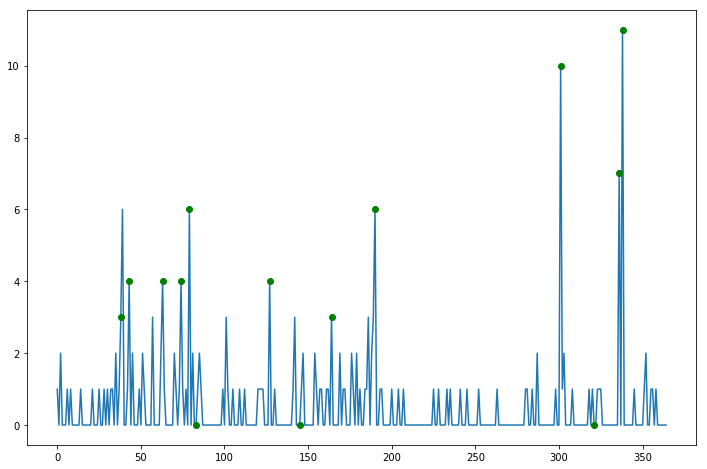

In [53]:
plt.figure(figsize=(12,8))
filt = (res.resid > 2*s) | (res.resid < -2*s)
plt.plot(df.iloc[:,8])
plt.plot(df[filt]['issues-new _ issues'],'o',color='g')

In [54]:
df[filt]['issues-new _ issues']

38      3.0
43      4.0
63      4.0
74      4.0
79      6.0
83      0.0
127     4.0
145     0.0
164     3.0
190     6.0
301    10.0
321     0.0
336     7.0
338    11.0
Name: issues-new _ issues, dtype: float64

## Less Active Repo

repo_id = 30001 git url : https://github.com/projectcontour/gimbal

#### Such repos were ocassionally active and their is continous slowdown over long period of time.
#### 60 days trend with weekly seasonality fits best for this repo.
#### Points outside 3rd standard deviation are good to classify as outliers.
#### There is less chance of skipping any anomaly and also rare to raise a false positive signal.

In [55]:
df_frame = time_series_metrics(30001)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/code-changes

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/issues-active

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/issues-closed

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/contributors-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/reviews

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/open-issues-count

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/reviews-accepted

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/reviews-declined



In [56]:
df_frame = df_frame.fillna(0)

In [57]:
df_frame.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-04-02,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2019-04-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


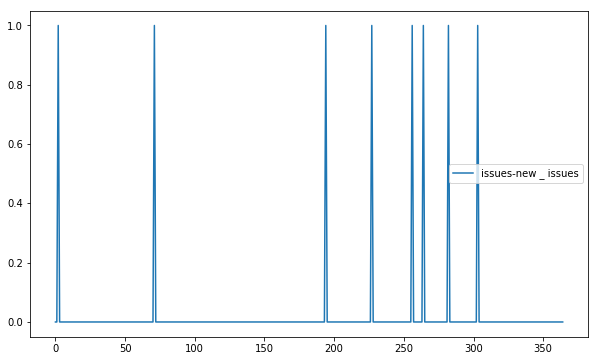

In [58]:
plt.figure(figsize=(10,6))
plt.plot(df_frame.iloc[:,8])
plt.legend()

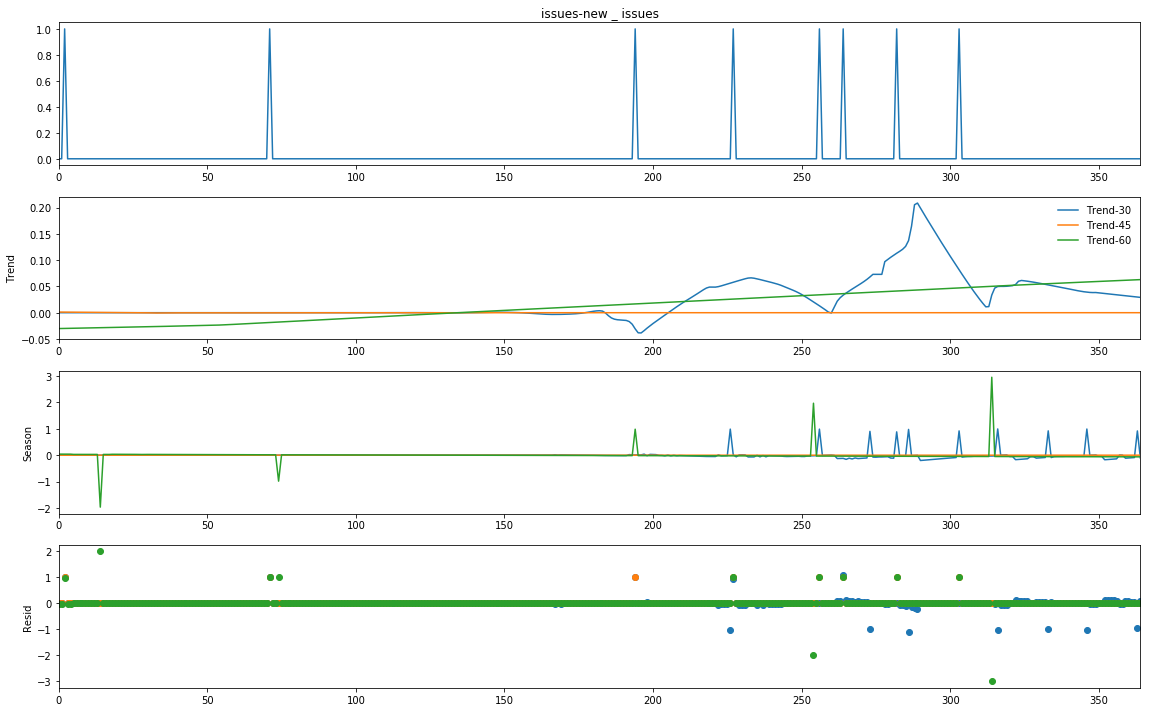

In [95]:
plt.rc('figure',figsize=(16,10))
stl = STL(df_frame.iloc[:,8], seasonal=5,trend=31,period=30,robust=True)
res = stl.fit()
fig = res.plot()
res_non_robust = STL(df_frame.iloc[:,8], seasonal=5,trend=45,period=44, robust=True).fit()
add_stl_plot(fig, res_non_robust,['Trend-30','Trend-45'])
res_non = STL(df_frame.iloc[:,8], seasonal=5,trend=61,period=60, robust=True).fit()
add_stl_plot(fig, res_non, ['Trend-30','Trend-45','Trend-60'])

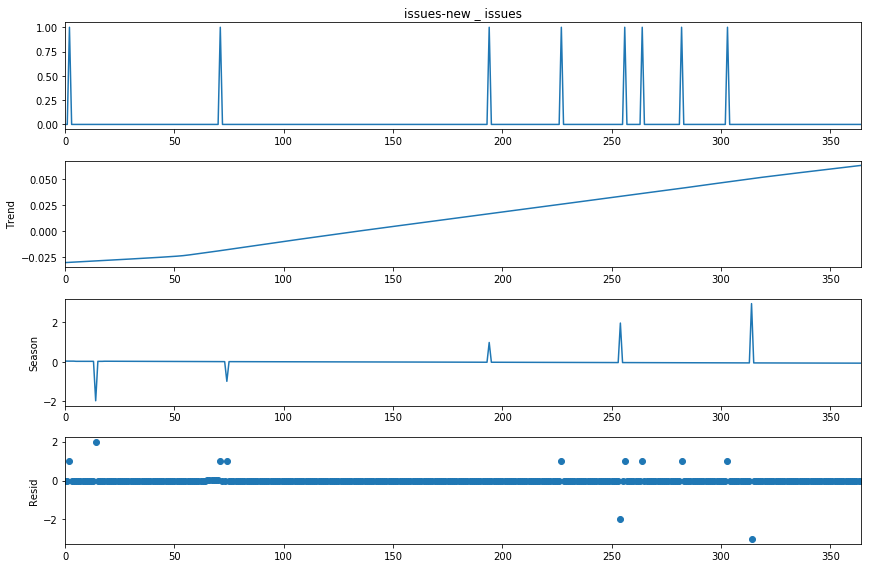

In [96]:
plt.rc('figure',figsize=(12,8))
stl = STL(df_frame.iloc[:,8], seasonal=5,trend=61,period=60,robust=True)
res = stl.fit()
fig = res.plot()

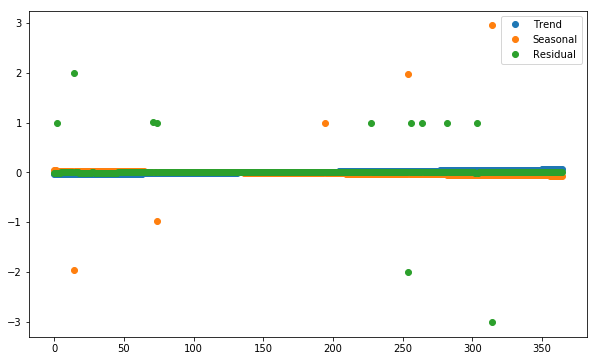

In [97]:
plt.figure(figsize=(10,6))
plt.plot(res.trend , 'o',label='Trend')
plt.plot(res.seasonal , 'o',label='Seasonal')
plt.plot(res.resid , 'o',label='Residual')
plt.legend()

In [98]:
std_resid = np.std(res.resid)
mean_resid = np.mean(res.resid)
print(std_resid)

0.26122316916780947


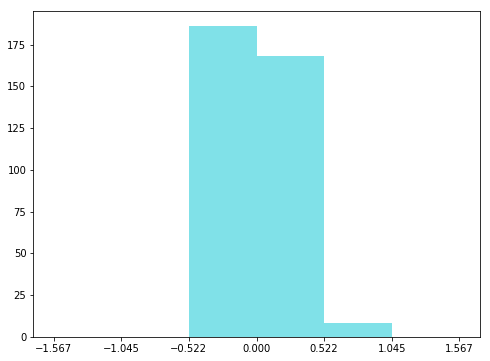

In [99]:
plt.figure(figsize=(8,6))
s=std_resid
bis = [-6*s,-4*s,-2*s,0,2*s,4*s,6*s,]
plt.hist(res.resid,bins=bis,color = '#80e1e8')
plt.xticks(bis)
plt.show()

In [100]:
np.mean(df_frame.iloc[:,8])

0.021917808219178082

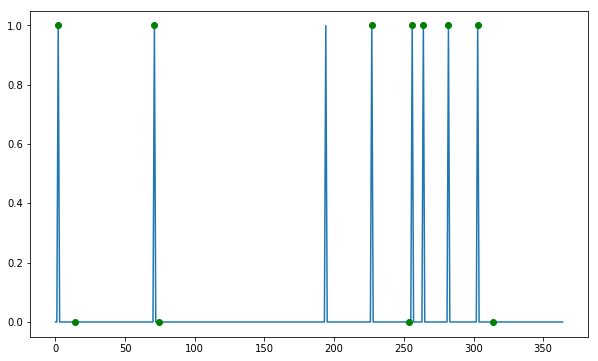

In [101]:
plt.figure(figsize=(10,6))
filt = (res.resid > 3*s) | (res.resid < -3*s)
plt.plot(df_frame.iloc[:,8])
plt.plot(df_frame[filt]['issues-new _ issues'],'o',color='g')